In [ ]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
from math import log

from tensorflow import keras
from collections import deque
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, precision_score, recall_score
import lightgbm as lgb
from typing import Callable
from collections import Counter

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Read the dataset from the text file
with open('/content/drive/MyDrive/Colab Notebooks/Thesis - Negative Ties/wiki-RfA.txt', 'r', encoding='utf-8') as file:
    dataset_text = file.read()

# Split the dataset text into individual records
records = dataset_text.strip().split('\n\n')

# Initialize empty lists for each column
src_list = []
tgt_list = []
vot_list = []
res_list = []
yea_list = []
dat_list = []
txt_list = []

# Extract values for each column from the records
for record in records:
    lines = record.strip().split('\n')
    record_dict = {}
    for line in lines:
        key, value = line.split(':', 1)
        record_dict[key.strip()] = value.strip()
    src_list.append(record_dict.get('SRC'))
    tgt_list.append(record_dict.get('TGT'))
    vot_list.append(record_dict.get('VOT'))
    res_list.append(record_dict.get('RES'))
    yea_list.append(record_dict.get('YEA'))
    dat_list.append(record_dict.get('DAT'))
    txt_list.append(record_dict.get('TXT'))

# Create a dataframe from the lists
df = pd.DataFrame({
    'SOURCE': src_list,
    'TARGET': tgt_list,
    'VOTE': vot_list,
    'RES': res_list,
    'YEA': yea_list,
    'DAT': dat_list,
    'TXT': txt_list
})

# Print the dataframe
df.head()

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."


Metrics of the initial graph:

In [ ]:
#Add the pandas dataframe to graph
g_init = nx.from_pandas_edgelist(df,
                            source = "SOURCE", #Source nodes
                            target = "TARGET", #Target node
                            edge_attr = "VOTE",
                            create_using = nx.DiGraph)

In [ ]:
#Negative edges count
negative_count = 0

  #for loop to count the negative edges
for u, v, data in g_init.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) < 0:
    negative_count += 1

In [ ]:
#Positive edge count
positive_count = 0

  #for loop to count the positive edges
for u, v, data in g_init.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) > 0:
    positive_count += 1

In [ ]:
#Neutral edge count
neutral_count = 0

  #for loop to count the neutral edges
for u, v, data in g_init.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) == 0:
    neutral_count += 1

In [ ]:
#Print results
print("The amount of negative edges in the initial graph is: ", negative_count)
print("The amount of positive edges in the initial graph is: ", positive_count)
print("The amount of neutral edges in the initial graph is: ", neutral_count)

The amount of negative edges in the initial graph is:  39080
The amount of positive edges in the initial graph is:  138247
The amount of neutral edges in the initial graph is:  11676


In [ ]:
# Delete rows with missing values from the 'VOTE' column
df.dropna(subset=['VOTE'], inplace=True)

In [ ]:
# Check for self-loops and remove corresponding rows:
df = df[df['SOURCE'] != df['TARGET']]

Now we remove dublicate edges that exist because many users run for adminship several times and keep the most recent ones:

In [ ]:
df['DAT'] = pd.to_datetime(df['DAT'], format = '%H:%M, %d %B %Y', errors='coerce')
df.sort_values(by='DAT', ascending = False, inplace=True)
df.drop_duplicates(subset=['SOURCE', 'TARGET'], keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)

## Using Snowball sampling with layers to sample a representative subgraph:
Results vary as the algorithm starts with 10 randomly picked seed nodes

In [ ]:
g = nx.from_pandas_edgelist(df, "SOURCE", "TARGET", edge_attr=["VOTE","RES","YEA","DAT","TXT"], create_using=nx.DiGraph)

In [ ]:
def snowball(graph, seed, num_layers):

    """ Function to do snowball sampling
    1. Convert the seed to the list if input is 1 node
    2. Loop over the amount of desired layers
      - In each loop we go through one layer of nodes and find neighbours
    3. Loop over the nodes in the current layers.
      - In each loop we add the connected nodes to the sample
    4. Transform sample to a subgraph
    """

    sample = set()
    visited = set(seed)
    current_layer = set(seed)

    # Convert seed to a list if it's a single node
    if isinstance(seed, str):
        seed = [seed]

    # Start snowball sampling and stop when we reach the desired number of layers
    for _ in range(num_layers):
        next_layer = set()

        # Iterate over the nodes in the current layer
        for node in current_layer:
            if node not in sample:
                sample.add(node)
                next_layer.update(graph.neighbors(node))

        # Update the current layer with the nodes in the next layer
        current_layer = next_layer - visited
        visited.update(next_layer)

    # Create a subgraph from the sample set
    sg = graph.subgraph(sample)

    # Return the sample subgraph
    return sg

In [ ]:
nodes = list(g.nodes())
snow_seed = random.sample(nodes, 10)
snow_nodes = snowball(g, seed = snow_seed, num_layers = 10)
print('Number of nodes in the initial graph: ', len(nodes))
print('Number of nodes in the snow_subgraph: ', len(snow_nodes.nodes()))

Number of nodes in the initial graph:  11381
Number of nodes in the snow_subgraph:  3452


In [ ]:
snow_subgraph = g.subgraph(snow_nodes)
print('Edge number of snow-subgraph: ', len(snow_subgraph.edges()))

Edge number of snow-subgraph:  119172


### Plot the in and out degree distribution of the snowball subgraph:

In [ ]:
# create a new dataframe based on the snowball_subgraph:
# Create a list to store the edge data
edge_data = []

# Iterate over the edges and extract the necessary information
for u, v, attrs in snow_subgraph.edges(data=True):
    edge_data.append((u, v, attrs["VOTE"], attrs["RES"], attrs["YEA"], attrs["DAT"], attrs["TXT"]))

# Create a dataframe from the edge data
df_sg = pd.DataFrame(edge_data, columns=['SOURCE', 'TARGET', 'VOTE','RES','YEA','DAT','TXT'])

In [ ]:
df_sg

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT
0,KnightLago,AlexandrDmitri,1,1,2010,2010-05-14 16:31:00,'''Support''' –
1,KnightLago,Cool3,1,1,2009,2009-06-20 19:20:00,'''Support''' - As nominator.
2,KnightLago,Synergy,1,-1,2009,2009-04-15 19:17:00,'''Support''' Good work at SPI. Demonstrated n...
3,KnightLago,Orlady,1,1,2009,2009-04-09 00:08:00,'''Support''' - Great work at SPI.
4,KnightLago,Ceranthor,-1,-1,2009,2009-03-13 20:56:00,'''Oppose''' per Seraphim and taking credit fo...
...,...,...,...,...,...,...,...
119167,Psy guy,Cryptic,1,1,2005,2005-11-05 18:24:00,'''Support''' RfA cliché #1 --
119168,Psy guy,FireFox,1,1,2005,2005-11-01 21:53:00,'''Support''' RfA cliché #1: I thought you wer...
119169,Psy guy,Acetic Acid,1,1,2005,2005-10-24 05:10:00,'''Support''' Without reservation. --
119170,Psy guy,Who,1,1,2005,2005-09-23 13:17:00,'''Support''' I have seen him around. I just ...


In [ ]:
df_sg_positive = df_sg[df_sg['VOTE'] =='1']
df_sg_negative = df_sg[df_sg['VOTE'] == '-1']
df_sg_neutral = df_sg[df_sg['VOTE']=='0']

In [ ]:
#Add the pandas dataframe to graph
g_pos = nx.from_pandas_edgelist(df_sg_positive,
                            source = "SOURCE", #Source nodes
                            target = "TARGET", #Target node
                            edge_attr = "VOTE",
                            create_using = nx.DiGraph)

g_neg = nx.from_pandas_edgelist(df_sg_negative,
                            source = "SOURCE", #Source nodes
                            target = "TARGET", #Target node
                            edge_attr = "VOTE",
                            create_using = nx.DiGraph)

g_neut = nx.from_pandas_edgelist(df_sg_neutral,
                            source = "SOURCE", #Source nodes
                            target = "TARGET", #Target node
                            edge_attr = "VOTE",
                            create_using = nx.DiGraph)

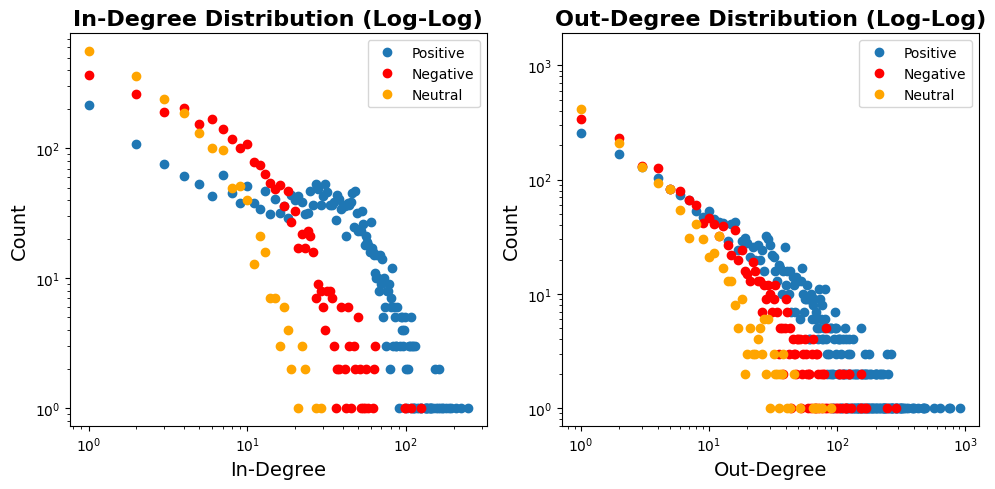

In [ ]:
from collections import Counter

# Calculate the in-degree for each class
pos_in_degrees = [d for n, d in g_pos.in_degree()]
neg_in_degrees = [d for n, d in g_neg.in_degree()]
neut_in_degrees = [d for n, d in g_neut.in_degree()]

# Calculate the out-degree for each class
pos_out_degrees = [d for n, d in g_pos.out_degree()]
neg_out_degrees = [d for n, d in g_neg.out_degree()]
neut_out_degrees = [d for n, d in g_neut.out_degree()]

# Create degree histograms for each class
pos_in_hist = Counter(pos_in_degrees)
neg_in_hist = Counter(neg_in_degrees)
neut_in_hist = Counter(neut_in_degrees)

pos_out_hist = Counter(pos_out_degrees)
neg_out_hist = Counter(neg_out_degrees)
neut_out_hist = Counter(neut_out_degrees)

# Plot the in-degree histograms for each class
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.loglog(list(pos_in_hist.keys()), list(pos_in_hist.values()), 'o', label='Positive', color='#1F77B4')
plt.loglog(list(neg_in_hist.keys()), list(neg_in_hist.values()), 'o', label='Negative', color='red')
plt.loglog(list(neut_in_hist.keys()), list(neut_in_hist.values()), 'o', label='Neutral', color='orange')
plt.xlabel('In-Degree', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('In-Degree Distribution (Log-Log)', fontsize=16, fontweight='bold')
plt.legend()

# Plot the out-degree histograms for each class
plt.subplot(1, 2, 2)
plt.loglog(list(pos_out_hist.keys()), list(pos_out_hist.values()), 'o', label='Positive', color='#1F77B4')
plt.loglog(list(neg_out_hist.keys()), list(neg_out_hist.values()), 'o', label='Negative', color='red')
plt.loglog(list(neut_out_hist.keys()), list(neut_out_hist.values()), 'o', label='Neutral', color='orange')
plt.xlabel('Out-Degree', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Out-Degree Distribution (Log-Log)', fontsize=16, fontweight='bold')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Negative edges count
negative_count = 0

  #for loop to count the negative edges
for u, v, data in snow_subgraph.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) < 0:
    negative_count += 1

#Positive edge count
positive_count = 0

  #for loop to count the positive edges
for u, v, data in snow_subgraph.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) > 0:
    positive_count += 1

#Neutral edge count
neutral_count = 0

  #for loop to count the neutral edges
for u, v, data in snow_subgraph.edges(data = True):
  if "VOTE" in data and int(data["VOTE"]) == 0:
    neutral_count += 1

#Print results
print("The amount of negative edges in the snow_subgraph is: ", negative_count)
print("The amount of positive edges in the snow_subgraph is: ", positive_count)
print("The amount of neutral edges in the snow_subgraph is: ", neutral_count)


The amount of negative edges in the snow_subgraph is:  22776
The amount of positive edges in the snow_subgraph is:  89182
The amount of neutral edges in the snow_subgraph is:  7214


## training LGBM on BFS-subgraph with graph features:

In [ ]:
def compute_metric(graph: nx.Graph, metrics: list[Callable], df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute metrics given within `metrics` list for each pair of nodes within `df.
    Args:
        graph (nx.Graph): Graph based on edges from `df`
        metrics (list[Callable]): Metrics to be computed
        df (pd.DataFrame): DataFrame with all edges between nodes

    Returns:
        pd.DataFrame: DataFrame with calculated metrics between nodes
    """

    def _compute_metric(graph: nx.Graph, metric: Callable, df: pd.DataFrame)->pd.DataFrame:
        node_pairs = list(zip(df.SOURCE, df.TARGET))
        generator = metric(graph, node_pairs)
        score_pairs = [score for _, _, score in generator]
        df[metric.__name__] = score_pairs
        return df

    for metric in metrics:
        df = _compute_metric(graph=graph.to_undirected(), metric=metric, df=df)
    return df

In [ ]:
## Updated code that also calculates positive and negative in-degrees of nodes:
def compute_clustering_and_degree(graph: nx.DiGraph, df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute clustering coef for each node as well as in and out degree, and page rank scores for each node
    Also added positive_in positive_out and negative_in, negative_out number of edges for each node
    These features are added as columns to existing dataframe with edges.

    Args:
        graph (nx.Graph): Graph based on edges from `df`
        df (pd.DataFrame): DataFrame with all edges between nodes

    Returns:
        pd.DataFrame: DataFrame with calculated metrics between nodes
    """

    clustering_dict = nx.algorithms.cluster.clustering(graph)
    clustering = pd.DataFrame(clustering_dict.items(), columns=["node", "value"])

    degree_in_dict = {node: graph.in_degree(node) for node in graph.nodes()}
    degree_in = pd.DataFrame(degree_in_dict.items(), columns=["node", "value"])

    degree_out_dict = {node: graph.out_degree(node) for node in graph.nodes()}
    degree_out = pd.DataFrame(degree_out_dict.items(), columns=["node", "value"])

    page_rank_dict = nx.pagerank(graph)
    page_rank = pd.DataFrame(page_rank_dict.items(),columns=["node", "value"])

    #Positive and negative indegree
    positive_indegrees = {}
    negative_indegrees = {}

     #For loop to loop over each node in the network
    for node in graph.nodes():

         #Get all the incoming edges for each node
         in_edges = graph.in_edges(node, data=True)

         #Store the amount of positive and negative edges in the right dictionary
         positive_edges = [edge for edge in in_edges if edge[2]['VOTE'] == '1']
         negative_edges = [edge for edge in in_edges if edge[2]['VOTE'] == '-1']
         positive_indegree = len(positive_edges)
         negative_indegree = len(negative_edges)
         positive_indegrees[node] = positive_indegree
         negative_indegrees[node] = negative_indegree

    # #Convert the dictionary to a dataframe
    positive_df = pd.DataFrame({'node': list(positive_indegrees.keys()), 'value': list(positive_indegrees.values())})
    negative_df = pd.DataFrame({'node': list(negative_indegrees.keys()), 'value': list(negative_indegrees.values())})

    dict_to_merge = {"clustering": clustering,
                     "degree_in": degree_in,
                     "degree_out": degree_out,
                     "page_rank": page_rank,
                     "positive_in" : positive_df,
                     "negative_in" : negative_df
                     }

    for name, dataframe in dict_to_merge.items():
        df = (
            df.merge(dataframe, how="left", left_on="SOURCE", right_on="node")
            .drop(columns=["node"])
            .rename(columns={"value": f"{name}_1"})
        )
        df = (
            df.merge(dataframe, how="left", left_on="TARGET", right_on="node")
            .drop(columns=["node"])
            .rename(columns={"value": f"{name}_2"})
        )
    return df

In [ ]:
metrics = [
    nx.resource_allocation_index,
    nx.jaccard_coefficient,
    nx.preferential_attachment,
]

In [ ]:
# Add graph attributes:
df_lgbm = compute_metric(df=df_sg, metrics=metrics, graph=snow_subgraph)
eigenv_centr = nx.eigenvector_centrality(snow_subgraph)
df_lgbm['eigen_1'] =df_sg['SOURCE'].map(eigenv_centr)
df_lgbm['eigen_2'] = df_sg['TARGET'].map(eigenv_centr)
df_lgbm= compute_clustering_and_degree(graph=snow_subgraph, df=df_sg)
# Compute the adjacency matrix
adj_matrix = nx.adjacency_matrix(snow_subgraph).toarray()
# Compute the cubed adjacency matrix which gives the number of balanced or imbalanced triangles in the graph
cubed_adj_matrix = np.linalg.matrix_power(adj_matrix, 3)
# Create a list of nodes from the sg graph to correspond them to the df_sg
node_list = list(snow_subgraph.nodes())
# Add a new column to the dataframe with cubed adjacency matrix elements
df_lgbm['cubed_adj_element'] = [cubed_adj_matrix[node_list.index(start)][node_list.index(end)] for start, end in zip(df_lgbm['SOURCE'], df_lgbm['TARGET'])]

In [ ]:
def fast_adjacency_matrix_power(adj_matrix, power):
    n = adj_matrix.shape[0]  # Number of nodes
    result = np.eye(n)       # Initialize the result as the identity matrix

    while power > 0:
        if power % 2 == 1:
            result = np.dot(result, adj_matrix)
        adj_matrix = np.dot(adj_matrix, adj_matrix)
        power = power // 2

    return result

adj_matrix_power4 = fast_adjacency_matrix_power(adj_matrix, 4)
#adj_matrix_power5 = fast_adjacency_matrix_power(adj_matrix, 5)

In [ ]:
df_lgbm['adj4_element'] = [adj_matrix_power4[node_list.index(start)][node_list.index(end)] for start, end in zip(df_lgbm['SOURCE'], df_lgbm['TARGET'])]
#df_lgbm['adj5_element'] = [adj_matrix_power5[node_list.index(start)][node_list.index(end)] for start, end in zip(df_lgbm['SOURCE'], df_lgbm['TARGET'])]

In [ ]:
df_lgbm

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT,resource_allocation_index,jaccard_coefficient,preferential_attachment,...,degree_out_1,degree_out_2,page_rank_1,page_rank_2,positive_in_1,positive_in_2,negative_in_1,negative_in_2,cubed_adj_element,adj4_element
0,Ginbot86,Connormah,1,-1,2010,2010-07-13 06:19:00,'''Support''' For sure. <sup>,0.041852,0.046512,3200,...,15,75,0.000138,0.000866,1,84,4,19,210,8872.0
1,Ginbot86,Fetchcomms,1,1,2010,2010-07-03 05:03:00,'''Support''' For sure. He's got what it takes...,0.223536,0.032491,5320,...,15,238,0.000138,0.000583,1,66,4,0,156,6509.0
2,Ginbot86,Theleftorium,1,1,2010,2010-06-25 22:23:00,'''Strong Support''' Absolutely. <sup>,0.035707,0.047619,2680,...,15,48,0.000138,0.000932,1,93,4,6,202,8022.0
3,Ginbot86,Checker Fred,-1,-1,2010,2010-06-25 22:21:00,'''Oppose''' per [[WP:NOTNOW]]. Your answers t...,0.003759,0.040000,120,...,15,0,0.000138,0.000107,1,0,4,6,17,570.0
4,Ginbot86,Ceranthor,1,1,2010,2010-04-18 00:52:00,'''Support''',0.072741,0.031153,6220,...,15,231,0.000138,0.001206,1,116,4,23,289,11484.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119242,Edokter,Remember the dot,1,-1,2007,2007-10-27 18:27:00,'''Support''' Dealing with images is tough eno...,0.034557,0.085714,2024,...,7,2,0.000115,0.000617,13,75,1,14,30,1401.0
119243,Edokter,RedirectCleanupBot,1,1,2007,2007-10-05 21:57:00,'''Support''' I'm convinced the bot will not d...,0.055797,0.079137,2816,...,7,0,0.000115,0.001037,13,114,1,9,37,1516.0
119244,Edokter,Missingno390,-1,-1,2007,2007-09-19 19:25:00,'''Oppose''' 51 edits? Appreciate your enthous...,0.000000,0.000000,66,...,7,0,0.000115,0.000101,13,0,1,3,2,64.0
119245,Edokter,EliminatorJR,-1,1,2007,2007-07-23 12:15:00,'''Oppose''' Not that it will make a differenc...,0.018942,0.072289,1474,...,7,25,0.000115,0.000174,13,39,1,3,9,481.0


We also sample 10000 entries to use them in the final stacked model. We make sure they have the same vote class frequencies as the snowball subgraph dataset and remove them from the df_lgbm dataframe.

In [ ]:
# Get the class counts from the 'VOTE' column
class_counts = df_lgbm['VOTE'].value_counts()

# Determine the total number of samples to take
sample_size = 10000

# Initialize an empty dataframe for the final test set
df_final_test_set = pd.DataFrame()

# Sample from each class proportionally to their frequencies without replacement
for vote_value, count in class_counts.items():
    # Calculate the number of samples to take from the current class
    class_sample_size = int(sample_size * (count / len(df_lgbm)))
    # Filter the dataframe by the current vote value
    df_vote = df_lgbm[df_lgbm['VOTE'] == vote_value]
    # Sample the required number of entries without replacement
    df_sampled = df_vote.sample(n=min(class_sample_size, count), random_state=42, replace=False)
    # Concatenate the sampled entries to the final test set
    df_final_test_set = pd.concat([df_final_test_set, df_sampled])

# Remove the sampled entries from the original dataframe
df_lgbm = df_lgbm.drop(df_final_test_set.index)

In [ ]:
#df_final_test_set
class_proportions = df_final_test_set['VOTE'].value_counts(normalize=True)
print(class_proportions)

1     0.748275
-1    0.191119
0     0.060606
Name: VOTE, dtype: float64


In [ ]:
df_final_test_set

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT,resource_allocation_index,jaccard_coefficient,preferential_attachment,...,degree_out_1,degree_out_2,page_rank_1,page_rank_2,positive_in_1,positive_in_2,negative_in_1,negative_in_2,cubed_adj_element,adj4_element
99880,Alison,Anthony Appleyard,1,1,2007,2007-04-11 18:13:00,"'''Support''' per nom. Also, things have moved...",0.089368,0.065517,14750,...,207,0,0.000349,0.000282,58,43,0,9,523,26361.0
63310,Ultraexactzz,Elen of the Roads,1,1,2010,2010-10-21 13:45:00,'''Support''' per the obvious reasons cited ab...,0.202693,0.090643,31476,...,213,42,0.000198,0.000857,35,93,2,5,912,46054.0
1606,Kbdank71,Horologium,1,1,2008,2008-04-24 13:50:00,Definitely. --,0.052237,0.036530,12070,...,131,34,0.000175,0.000419,20,58,1,0,272,15433.0
51578,Pagrashtak,Protonk,1,1,2008,2008-10-15 14:17:00,'''Support''' Protonk's AFD contributions are ...,0.037271,0.014286,7920,...,9,115,0.000271,0.000420,39,64,0,2,39,1479.0
93905,Johntex,Darthgriz98,1,1,2007,2007-04-08 23:39:00,'''Support''' per the candidates good contribu...,0.009564,0.012821,6225,...,59,44,0.000217,0.000205,28,39,1,0,93,4470.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113379,Kudpung,Blurpeace,0,1,2010,2010-04-26 07:13:00,'''Neutral''' - Basically as per Shadowjams o...,0.166346,0.109848,14982,...,190,18,0.000621,0.000360,55,52,7,2,575,23950.0
31633,Juliancolton,Arienh4,0,-1,2008,2008-06-09 19:41:00,"'''Neutral''' Sorry, but I'm afraid I can't su...",0.017387,0.008850,2700,...,393,2,0.001181,0.000111,96,0,6,2,85,3162.0
108925,Stifle,Download,0,-1,2009,2009-05-06 19:11:00,"Mostly OK, but nominating an article for AFD a...",1.369540,0.164596,91200,...,561,120,0.000194,0.000276,47,23,2,16,1242,64084.0
87437,Tinucherian,Izzy007,0,-1,2008,2008-05-27 05:15:00,'''Neutral'''( with weak oppose inclination) ...,0.049931,0.053498,10143,...,130,0,0.000758,0.000288,99,13,1,25,321,13797.0


This train test split will be used for the BERT model as well:

In [ ]:
y = df_lgbm['VOTE']
df_lgbm_model = df_lgbm.drop(columns=["TARGET", "SOURCE",'VOTE','RES','YEA','DAT','TXT'])
X_train, X_test, y_train, y_test = train_test_split(df_lgbm_model, y, test_size=0.10, shuffle=True, stratify = y, random_state=42)
model = lgb.LGBMClassifier(n_estimators=1000, class_weight = 'balanced') # maybe consider class_weight = 'balanced' which gives worse accuracy but better recall for the neutral class
model.fit(X_train, y_train)
preds = model.predict(X_test)
acc = accuracy_score(y_test, preds)
precision = precision_score(y_test, preds, average=None)
recall = recall_score(y_test, preds, average=None)
conf_matrix = confusion_matrix(y_test, preds)

print(f"Precision: {precision}, recall: {recall}, accuracy: {acc}")
print(conf_matrix)

Precision: [0.55897821 0.23180873 0.92644843], recall: [0.71230254 0.33685801 0.82750184], accuracy: 0.7757437070938215
[[1488  262  339]
 [ 241  223  198]
 [ 933  477 6764]]


In [ ]:
print("Feature importance lgbm model: ")
sorted(list(zip(df_lgbm_model.columns, model.feature_importances_)),
       key=lambda x: x[1],
       reverse = True)

Feature importance lgbm model: 


[('jaccard_coefficient', 6694),
 ('resource_allocation_index', 6098),
 ('clustering_1', 5850),
 ('page_rank_1', 5292),
 ('eigen_1', 5100),
 ('negative_in_2', 5062),
 ('cubed_adj_element', 5028),
 ('adj4_element', 4947),
 ('preferential_attachment', 4939),
 ('clustering_2', 4869),
 ('positive_in_2', 4728),
 ('degree_out_1', 4654),
 ('page_rank_2', 4411),
 ('positive_in_1', 4001),
 ('degree_in_2', 4000),
 ('eigen_2', 3970),
 ('degree_out_2', 3588),
 ('degree_in_1', 3453),
 ('negative_in_1', 3316)]

Grid search for hyperparameter tuning of the LGBM model:
Very intense time-wise.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
     'learning_rate': [0.1, 0.05],
     'n_estimators': [500, 1000, 1500],
     'num_leaves': [30, 50, 100]
}

lgbm = lgb.LGBMClassifier()

grid_search = GridSearchCV(estimator = lgbm, param_grid = param_grid, cv =3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=LGBMClassifier(),
             param_grid={'learning_rate': [0.1, 0.05],
                         'n_estimators': [500, 1000, 1500],
                         'num_leaves': [30, 50, 100]})

In [ ]:
best_params = grid_search.best_params_
# # Add class_weight='balanced' to the best parameters
best_params['class_weight'] = 'balanced'
print(best_params)
#tuned_lgbm = lgb.LGBMClassifier.set_params(**best_params)
tuned_lgbm = grid_search.best_estimator_
tuned_lgbm.fit(X_train, y_train)
tuned_preds = tuned_lgbm.predict(X_test)
acc = accuracy_score(y_test, tuned_preds)
precision = precision_score(y_test, tuned_preds, average=None)
recall = recall_score(y_test, tuned_preds, average=None)
conf_matrix = confusion_matrix(y_test, tuned_preds)

print(f"Precision: {precision}, recall: {recall}, accuracy: {acc}")
print(conf_matrix)

{'learning_rate': 0.05, 'n_estimators': 1000, 'num_leaves': 30, 'class_weight': 'balanced'}
Precision: [0.69906129 0.48076923 0.86659267], recall: [0.60603159 0.0755287  0.95522388], accuracy: 0.8351487414187643
[[1266   26  797]
 [ 207   50  405]
 [ 338   28 7808]]


In [ ]:
print("Feature importance of tuned_lgbm model: ")
sorted(list(zip(df_lgbm_model.columns, tuned_lgbm.feature_importances_)),
       key=lambda x: x[1],
       reverse = True)

Feature importance of tuned_lgbm model: 


[('clustering_1', 6086),
 ('jaccard_coefficient', 5900),
 ('page_rank_1', 5787),
 ('resource_allocation_index', 5418),
 ('eigen_1', 5403),
 ('degree_out_1', 5334),
 ('positive_in_2', 5104),
 ('negative_in_2', 4925),
 ('preferential_attachment', 4317),
 ('positive_in_1', 4301),
 ('cubed_adj_element', 4279),
 ('adj4_element', 4278),
 ('clustering_2', 4173),
 ('page_rank_2', 3881),
 ('degree_in_2', 3758),
 ('degree_in_1', 3626),
 ('eigen_2', 3566),
 ('negative_in_1', 3559),
 ('degree_out_2', 3305)]

Plot feature importance of the LGBM model:

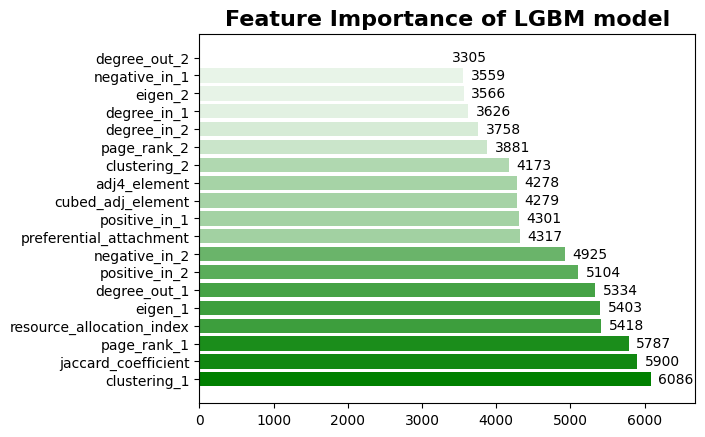

In [ ]:
import matplotlib.colors as mcolors

data = sorted(list(zip(df_lgbm_model.columns, tuned_lgbm.feature_importances_)),
       key=lambda x: x[1],
       reverse = True)

# Extract predictor names and values
predictors = [entry[0] for entry in data]
values = np.array([entry[1] for entry in data])

# Normalize values between 0 and 1
normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))

# Define a color map
cmap = mcolors.LinearSegmentedColormap.from_list(
    'custom_cmap', [(1.0, 1.0, 1.0), (0.0, 0.5, 0.0)]
)

# Create the bar plot with colored bars
fig, ax = plt.subplots()
bars = ax.barh(predictors, values, color=cmap(normalized_values))

# Add x-axis values at the end of each bar
for i, v in enumerate(values):
    ax.text(v + 100, i, str(v), color='black', va='center')

# Set the title
ax.set_title("Feature Importance of LGBM model", fontsize=16, fontweight='bold')

# Increase the size of the x-axis limit
ax.set_xlim(right=np.max(values) + 600)

# Show the plot
plt.show()

In [ ]:
print(f'PROPORTION OF TARGET IN THE ORIGINAL DATA\n{df_lgbm["VOTE"].value_counts() / len(df_lgbm)}\n\n'+
      f'PROPORTION OF TARGET IN THE TRAINING SET\n{y_train.value_counts() / len(y_train)}\n\n'+
      f'PROPORTION OF TARGET IN THE TEST SET\n{y_test.value_counts() / len(y_test)}')


PROPORTION OF TARGET IN THE ORIGINAL DATA
1     0.748206
-1    0.191189
0     0.060605
Name: VOTE, dtype: float64

PROPORTION OF TARGET IN THE TRAINING SET
1     0.748207
-1    0.191186
0     0.060606
Name: VOTE, dtype: float64

PROPORTION OF TARGET IN THE TEST SET
1     0.748192
-1    0.191213
0     0.060595
Name: VOTE, dtype: float64


Storing LGBM predictions of the test set for stacking model:

In [ ]:
lgbm_preds = tuned_preds

## Fitting a DistilBERT model:

In [ ]:
X_train_bert = df_lgbm.loc[X_train.index, 'TXT']
y_train_bert = df_lgbm.loc[X_train.index, 'VOTE']
X_test_bert = df_lgbm.loc[X_test.index, 'TXT']
y_test_bert = df_lgbm.loc[X_test.index, 'VOTE']

In [ ]:
# Remove terms such as '''Support''', '''Oppose''' in the text column
def preprocess(to_clean):
    to_clean = to_clean.astype(str)
    to_clean = to_clean.str.replace(r"'''([^']*)'''", '', regex=True)
    return(to_clean)

X_train_bert = preprocess(X_train_bert)
X_test_bert = preprocess(X_test_bert)

X_train_bert = list(X_train_bert.values)
X_test_bert = list(X_test_bert.values)
y_train_bert = list(y_train_bert.values)
y_test_bert = list(y_test_bert.values)

label_mapping = {'1': 0, '0': 1, '-1': 2}
y_train_bert = [label_mapping[label] for label in y_train_bert]
y_test_bert= [label_mapping[label] for label in y_test_bert]

labels = ['positive', 'neutral', 'negative']

In [ ]:
# we also need a validation set to select the model with the most optimal parameters.
# We get this validation set by just using the half of the test set.

# First we have to save the initial test set in order to be able to combine models in the ensemble method:
X_test_bert_without_val_split = X_test_bert
y_test_bert_without_val_split = y_test_bert

X_test_bert, X_val_bert, y_test_bert, y_val_bert = train_test_split(X_test_bert, y_test_bert, test_size=0.5, stratify = y_test_bert, random_state=1)

## distilBERT model:
"A smaller general-purpose language representation model, called DistilBERT, which can then be fine-tuned with good performances on a wide range of tasks like its larger counterparts. While most prior work investigated the use of distillation for building task-specific models, we leverage knowledge distillation during the pre-training phase and show that it is possible to reduce the size of a BERT model by 40%, while retaining 97% of its language understanding capabilities and being 60% faster."

Paper:

 Sanh, V., Debut, L., Chaumond, J., & Wolf, T. (2019). DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter. arXiv preprint arXiv:1910.01108.

In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

import tensorflow as tf
!pip install transformers -q
from transformers import DistilBertTokenizerFast

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-cased')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.5 MB/s eta 0:00:00


<Axes: >

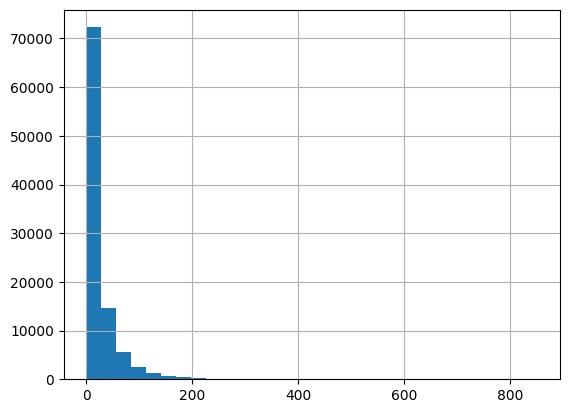

In [ ]:
# Length Distribution of all text sequences in train set:
seq_len = [len(i.split()) for i in X_train_bert]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
train_encodings = tokenizer(X_train_bert, truncation=True, padding=True, max_length=128) # convert input strings to BERT encodings
test_encodings = tokenizer(X_test_bert, truncation=True, padding=True,  max_length=128)
val_encodings = tokenizer(X_val_bert, truncation=True, padding=True, max_length=128)

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train_bert
)).shuffle(1000).batch(16) # convert the encodings to Tensorflow objects
val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    y_val_bert
)).batch(64)
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test_bert
)).batch(64)

In [ ]:
from transformers import TFDistilBertForSequenceClassification

model2 = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-cased',
                                                           num_labels=len(labels))
callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0,
                      mode='min', restore_best_weights=True)]

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model2.compile(optimizer=optimizer, loss=loss, metrics="accuracy")

Some layers from the model checkpoint at distilbert-base-cased were not used when initializing TFDistilBertForSequenceClassification: ['vocab_layer_norm', 'vocab_transform', 'vocab_projector', 'activation_13']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier', 'dropout_19', 'pre_classifier']
You should probably TRAIN this model on a down-stream task to be able to use it fo

In [ ]:
BERTmodel_exp = model2.fit(train_dataset,
                epochs=3,
                callbacks=callbacks,
                validation_data=val_dataset,
                batch_size=32, verbose=1)      # 32 is used as a rule of thumb, tried a batch of 128 size leading to a decrease in accuracy

Epoch 1/3
6146/6146 [==============================] - 580s 90ms/step - loss: 0.3211 - accuracy: 0.8804 - val_loss: 0.2720 - val_accuracy: 0.9006
Epoch 2/3
6146/6146 [==============================] - 492s 80ms/step - loss: 0.2332 - accuracy: 0.9152 - val_loss: 0.2632 - val_accuracy: 0.9054
Epoch 3/3
6146/6146 [==============================] - 489s 80ms/step - loss: 0.1880 - accuracy: 0.9334 - val_loss: 0.2740 - val_accuracy: 0.9050


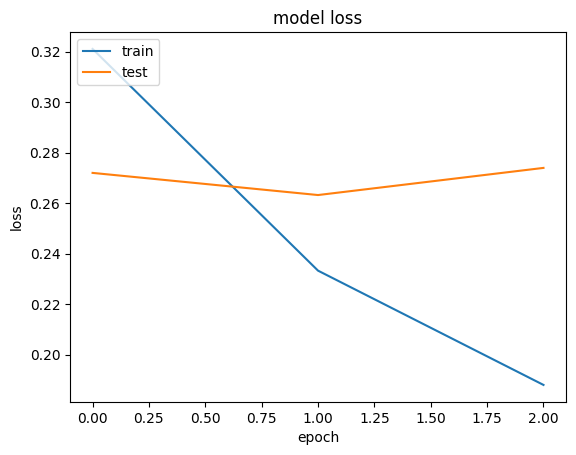

In [ ]:
# summarize history for loss
plt.plot(BERTmodel_exp.history['loss'])
plt.plot(BERTmodel_exp.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

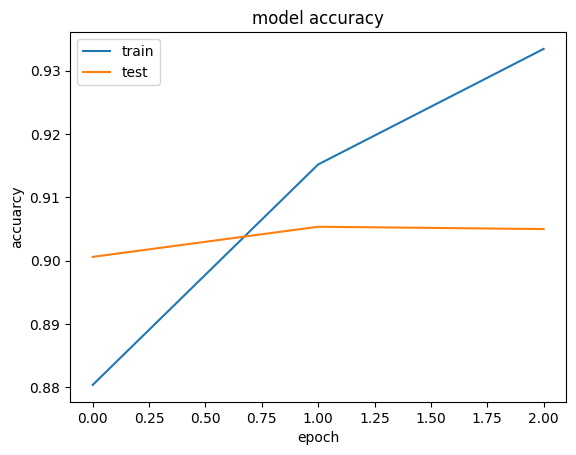

In [ ]:
# summarize history for accuracy
plt.plot(BERTmodel_exp.history['accuracy'])
plt.plot(BERTmodel_exp.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuarcy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Now we plot performance metrics of the Bert model on half of the test set:

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

logits = model2.predict(test_dataset)
y_preds = np.argmax(logits[0], axis=1)
print(classification_report(y_test_bert, y_preds, target_names=labels))

86/86 [==============================] - 9s 85ms/step
              precision    recall  f1-score   support

    positive       0.95      0.96      0.96      4087
     neutral       0.54      0.43      0.48       331
    negative       0.79      0.82      0.81      1044

    accuracy                           0.90      5462
   macro avg       0.76      0.74      0.75      5462
weighted avg       0.90      0.90      0.90      5462



Get DistilBert predictions of the test set:

In [ ]:
test_without_val_split_encodings = tokenizer(X_test_bert_without_val_split, truncation=True, padding=True,  max_length=128)

test_dataset_without_val_split = tf.data.Dataset.from_tensor_slices((
    dict(test_without_val_split_encodings),
    y_test_bert_without_val_split
    )).batch(64)

logits = model2.predict(test_dataset_without_val_split)
y_preds = np.argmax(logits[0], axis=1)

171/171 [==============================] - 14s 85ms/step


In [ ]:
print(len(y_preds))
print(len(lgbm_preds))

10925
10925


In [ ]:
X_test_indices = X_test.index

# Create a new dataframe with X_test and their corresponding attributes
df_test_preds = df_sg.loc[X_test_indices].copy()  # Copy the relevant rows from the original dataframe
df_test_preds['lgbm_preds'] = lgbm_preds

bert_test_preds = y_preds
label_mapping = {0: 1, 1: 0, 2: -1}            # re-encode bert preds to be comparable with lgbm preds
bert_test_preds = [label_mapping[label] for label in bert_test_preds]
df_test_preds['bert_preds'] = bert_test_preds
df_test_preds['y_test'] = y_test
df_test_preds.to_csv('df_test_preds.csv')
df_test_preds.head()

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT,resource_allocation_index,jaccard_coefficient,preferential_attachment,eigen_1,eigen_2,lgbm_preds,bert_preds,y_test
83277,DragonflySixtyseven,Newyorkbrad,1,1,2007,2007-01-16 01:36:00,"Perfunctory '''support''', because although I'...",0.348599,0.063063,77355,0.004429,0.052292,1,1,1
44428,The Rambling Man,Rklawton,1,1,2007,2007-03-06 18:46:00,'''Keep on Ramblin' support''',0.124969,0.065972,10222,0.028472,0.009257,1,1,1
59206,IMatthew,Enigmaman,1,-1,2009,2009-01-07 21:45:00,"'''Strong support''' <font face=""cursive"">'''",0.541305,0.251412,49020,0.048147,0.081999,1,1,1
102164,Silsor,Salsa Shark,1,1,2004,NaT,Support. I have seen Salsa Shark appear frequ...,0.000000,0.000000,678,0.027942,0.000496,1,1,1
84627,Euryalus,Backslash Forwardslash,1,1,2009,2009-05-29 04:16:00,'''Support''' - a strong content editor who ha...,0.182060,0.148305,17238,0.024479,0.051248,1,1,1


## Stacking classifier where we use the predictions of the DistilBert and LGBM models on the test set to train the stacked Classifier and evaluate its performance on the df_final_test_set. Also test the performance on that set for the other two classifiers.

First we create a final_test_set dataframe built of predictions from DistilBert and LGBM models on the final_test_set data:

In [ ]:
# working with df_final_test_set
def preprocess(to_clean):
    to_clean = to_clean.astype(str)
    to_clean = to_clean.str.replace(r"'''([^']*)'''", '', regex=True)
    return(to_clean)

X_test_final_bert = df_final_test_set['TXT']
y_test_final_bert = df_final_test_set['VOTE']

X_test_final_bert = preprocess(X_test_final_bert)
X_test_final_bert = list(X_test_final_bert.values)
y_test_final_bert = list(y_test_final_bert.values)

label_mapping = {'1': 0, '0': 1, '-1': 2}
y_test_final_bert= [label_mapping[label] for label in y_test_final_bert]

labels = ['positive', 'neutral', 'negative']

test_final_encodings = tokenizer(X_test_final_bert, truncation=True, padding=True,  max_length=128)

test_final_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_final_encodings),
    y_test_final_bert
)).batch(64)

In [ ]:
logits = model2.predict(test_final_dataset)
y_preds = np.argmax(logits[0], axis=1)

bert_test_preds = y_preds
label_mapping = {0: 1, 1: 0, 2: -1}
bert_test_final_preds = [label_mapping[label] for label in bert_test_preds]
df_final_test_set['bert_final_preds'] = bert_test_final_preds

157/157 [==============================] - 13s 85ms/step


In [ ]:
logits2 = model2.predict(test_final_dataset)[0]

# Apply softmax to convert logits to probabilities
probs = tf.nn.softmax(logits2, axis=1).numpy()
bert_test_final_preds_proba = probs                 ### Important for ROC CURVE

157/157 [==============================] - 13s 84ms/step


In [ ]:
X_final_lgbm = df_final_test_set.drop(columns=["TARGET", "SOURCE",'VOTE','RES','YEA','DAT','TXT','bert_final_preds'])


lgbm_test_final_preds = model.predict(X_final_lgbm)
lgbm_test_final_preds_proba = model.predict_proba(X_final_lgbm)    ### Important for ROC CURVE
df_final_test_set['lgbm_final_preds'] = lgbm_test_final_preds

In [ ]:
df_final_test_set

,SOURCE,TARGET,VOTE,RES,YEA,DAT,TXT,resource_allocation_index,jaccard_coefficient,preferential_attachment,...,page_rank_1,page_rank_2,positive_in_1,positive_in_2,negative_in_1,negative_in_2,cubed_adj_element,adj4_element,bert_final_preds,lgbm_final_preds
48062,Protonk,Suntag,1,-1,2008,2008-12-25 01:40:00,'''Excuse the language support''' Abso-*@#&ing...,0.222270,0.170732,12375,...,0.000422,0.000701,64,49,2,18,684,27619.0,1,1
51434,Khoikhoi,Newyorkbrad,1,1,2007,2007-01-15 00:18:00,"'''Support'''. <tt class=""plainlinks"">",1.402605,0.193863,162159,...,0.000773,0.000953,82,164,6,0,2690,147532.0,1,1
80488,Diannaa,TommyBoy,1,1,2012,2012-11-14 02:18:00,'''Support'''; the user seems clueful and inte...,0.101648,0.132353,5925,...,0.000305,0.001039,37,60,5,15,227,7284.0,1,1
57131,Wikipedialuva,Evilclown93,1,1,2007,2007-06-23 22:23:00,'''Strong Support''' I think this user would b...,0.000870,0.009524,873,...,0.000099,0.000337,0,57,7,0,10,236.0,1,1
105845,Ged UK,Someguy1221,1,1,2009,2009-03-18 20:32:00,"'''Support''' looks good to me, no alarms, bui...",0.124182,0.097046,15675,...,0.000641,0.000224,53,39,2,0,206,9056.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50931,WBOSITG,It Is Me Here,0,-1,2008,2008-08-18 17:51:00,"To begin, thanks for trying to gain the tools ...",0.149191,0.105769,26564,...,0.000611,0.000612,80,56,6,15,816,35803.0,-1,1
92909,Spebi,Chunky Rice,0,1,2007,2007-08-31 09:36:00,"'''Neutral''', per Hersfold's comments. –",0.073556,0.102564,5280,...,0.000201,0.000160,43,25,0,5,300,13480.0,1,1
84613,Alkivar,Radiant!,0,1,2005,NaT,<s>Currently I oppose Radiant! for admin</s> 1...,0.996382,0.157171,83190,...,0.000656,0.000416,58,56,35,5,288,11057.0,0,1
100961,EVula,Captmondo,0,-1,2007,2007-09-18 15:22:00,"I understand (and respect, and for the most pa...",0.017628,0.033113,3840,...,0.000528,0.000152,44,15,0,10,222,10081.0,-1,0


Fit the stacking classifier using a Random Forest model on the predictions of the test set (not the final_test_set!):

In [ ]:
from sklearn.ensemble import RandomForestClassifier
stacking_model = RandomForestClassifier(n_estimators=100, random_state=42)

In [ ]:
lgbm_test_preds = df_test_preds['lgbm_preds']
bert_test_preds = df_test_preds['bert_preds']
y_test = df_test_preds['y_test']

# Transform the 'lgbm_preds' and 'y_test' column values to floats and integers using the label mapping
# Label mapping dictionary
label_mapping = {'1': 1, '0': 0, '-1': -1}

data_stacked_test = {'lgbm_preds': lgbm_test_preds, 'bert_preds': bert_test_preds, 'y_test': y_test}
df_test_stackedClass = pd.DataFrame(data_stacked_test)
df_test_stackedClass['lgbm_preds'] = df_test_stackedClass['lgbm_preds'].map(label_mapping)
df_test_stackedClass['y_test'] = df_test_stackedClass['y_test'].map(label_mapping)

In [ ]:
df_test_stackedClass

,lgbm_preds,bert_preds,y_test
0,-1,1,1
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1
...,...,...,...
10934,-1,-1,-1
10935,-1,-1,-1
10936,-1,-1,-1
10937,1,-1,-1


In [ ]:
y_train_stack = df_test_stackedClass['y_test']
X_train_stack = df_test_stackedClass.drop(columns=['y_test'])

stacking_model.fit(X_train_stack, y_train_stack)

RandomForestClassifier(random_state=42)

## Now use the predictions from final_test_set of bert and lgbm to evaluate the performance of stack classifier on final_test_set data:

In [ ]:
X_test_stack = df_final_test_set[['lgbm_final_preds','bert_final_preds']]
X_test_stack.rename(columns={'lgbm_final_preds': 'lgbm_preds', 'bert_final_preds': 'bert_preds'}, inplace=True)
stackClassifier_y_test_final_preds = stacking_model.predict(X_test_stack)
stackClassifier_test_final_preds_proba = stacking_model.predict_proba(X_test_stack)  ## Important for ROC curve

<ipython-input-71-56af4f6576e7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_stack.rename(columns={'lgbm_final_preds': 'lgbm_preds', 'bert_final_preds': 'bert_preds'}, inplace=True)


In [ ]:
df_final_test_set['stacked_preds'] = stackClassifier_y_test_final_preds

In [ ]:
label_mapping = {'0': 0, '1': 1, '-1': -1}            # this might be necessary
lgbm_test_final_preds_correct = [label_mapping[label] for label in df_final_test_set['lgbm_final_preds']]
df_final_test_set['lgbm_final_preds'] =lgbm_test_final_preds_correct
vote_test_final_correct =  [label_mapping[label] for label in df_final_test_set['VOTE']]
df_final_test_set['VOTE'] = vote_test_final_correct

In [ ]:
df_final_test_set.to_csv('df_final_test_set_preds.csv')
df_final_test_set

Precision, Recall, F1-score and Confusion matrix of models in final_test_set:

In [ ]:
accBertFinal = accuracy_score(df_final_test_set['VOTE'], df_final_test_set['bert_final_preds'])
precisionBertFinal = precision_score(df_final_test_set['VOTE'], df_final_test_set['bert_final_preds'], average=None)
recallBertFinal = recall_score(df_final_test_set['VOTE'], df_final_test_set['bert_final_preds'], average=None)
conf_matrixBertFinal = confusion_matrix(df_final_test_set['VOTE'], df_final_test_set['bert_final_preds'])
print("Performance of Bert in final test set: ")
print(f"Precision: {precisionBertFinal}, recall: {recallBertFinal}, accuracy: {accBertFinal}")
print(conf_matrixBertFinal)

Performance of Bert in final test set: 
Precision: [0.78553861 0.66763006 0.95012469], recall: [0.83568812 0.38181818 0.96752205], accuracy: 0.906881376275255
[[1597   60  254]
 [ 248  231  126]
 [ 188   55 7239]]


In [ ]:
accLgbmFinal = accuracy_score(df_final_test_set['VOTE'], df_final_test_set['lgbm_final_preds'])
precisionLgbmFinal = precision_score(df_final_test_set['VOTE'], df_final_test_set['lgbm_final_preds'], average=None)
recallLgbmFinal = recall_score(df_final_test_set['VOTE'], df_final_test_set['lgbm_final_preds'], average=None)
conf_matrixLgbmFinal = confusion_matrix(df_final_test_set['VOTE'], df_final_test_set['lgbm_final_preds'])
print("Performance of Lgbm in final test set: ")
print(f"Precision: {precisionLgbmFinal}, recall: {recallLgbmFinal}, accuracy: {accLgbmFinal}")
print(conf_matrixLgbmFinal)

Performance of Lgbm in final test set: 
Precision: [0.57985672 0.23296159 0.92402464], recall: [0.72004186 0.3107438  0.84202085], accuracy: 0.7865573114622925
[[1376  229  306]
 [ 205  188  212]
 [ 792  390 6300]]


In [ ]:
accStackFinal = accuracy_score(df_final_test_set['VOTE'], stackClassifier_y_test_final_preds)
precisionStackFinal = precision_score(df_final_test_set['VOTE'], stackClassifier_y_test_final_preds, average=None)
recallStackFinal = recall_score(df_final_test_set['VOTE'], stackClassifier_y_test_final_preds, average=None)
conf_matrixStackFinal = confusion_matrix(df_final_test_set['VOTE'], stackClassifier_y_test_final_preds)
print("Performance of Stacked Model in final test set: ")
print(f"Precision: {precisionStackFinal}, recall: {recallStackFinal}, accuracy: {accStackFinal}")
print(conf_matrixStackFinal)

Performance of Stacked Model in final test set: 
Precision: [0.80333525 0.48125    0.95012469], recall: [0.73103087 0.50909091 0.96752205], accuracy: 0.8945789157831566
[[1397  260  254]
 [ 171  308  126]
 [ 171   72 7239]]


## Plotting performance metrics of lgbm, bert and stackedRandomForeset model on the final test set:

### First an ROC curve using prediction probabilities of each model on the final test set:

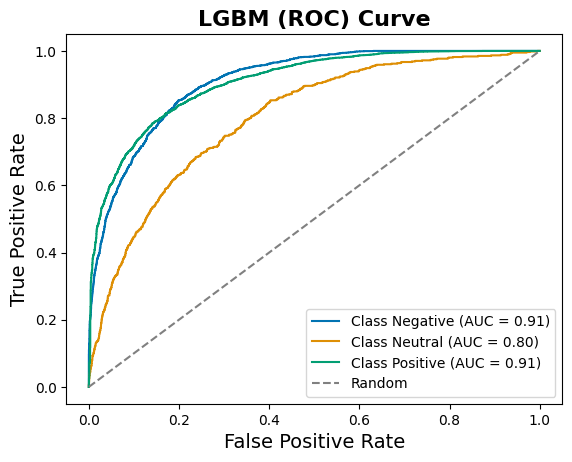

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import seaborn as sns
# Binarize the true labels
y_test = df_final_test_set['VOTE']

# Map your class labels to the integer representation
class_mapping = {1: 2, 0: 1, -1: 0}
class_labels = ['Negative', 'Neutral', 'Positive']

# Apply the class mapping to your true labels
y_test_encoded = np.array([class_mapping[label] for label in y_test])

y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])

color_palette = sns.color_palette("colorblind")

# Compute the false positive rate, true positive rate, and area under the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], lgbm_test_final_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=color_palette[i], label='Class {} (AUC = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('LGBM (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

Secondly for DistilBert:

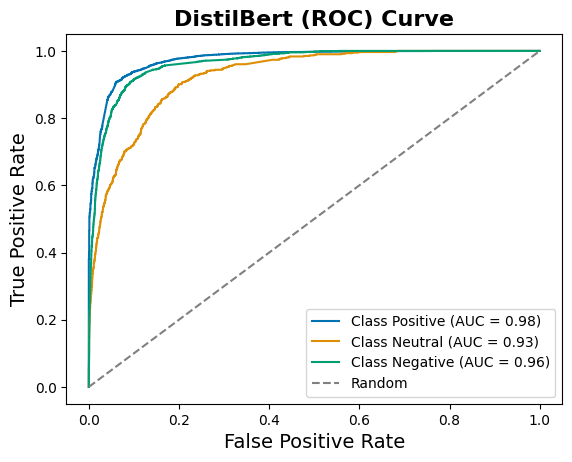

In [ ]:
# Map your class labels to the integer representation
class_mapping = {1: 0, 0: 1, -1: 2}
class_labels = ['Positive', 'Neutral', 'Negative']

# Apply the class mapping to your true labels
y_test_encoded = np.array([class_mapping[label] for label in y_test])

y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])

color_palette = sns.color_palette("colorblind")

# Compute the false positive rate, true positive rate, and area under the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], bert_test_final_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=color_palette[i], label='Class {} (AUC = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('DistilBert (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

Finally for Stacking Ensemble Model:

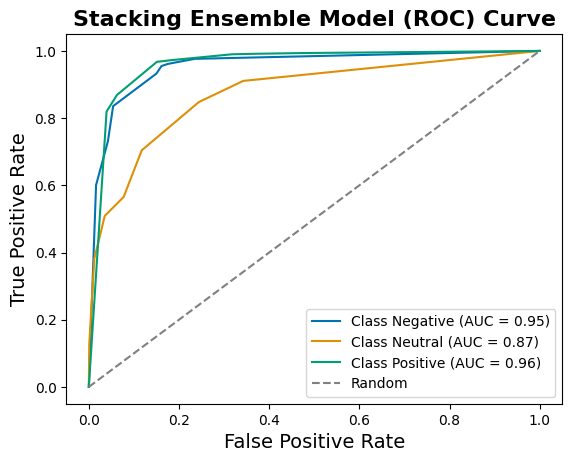

In [ ]:
# Map class labels to the integer representation
class_mapping = {1: 2, 0: 1, -1: 0}
class_labels = ['Negative', 'Neutral', 'Positive']

# Apply the class mapping to true labels
y_test_encoded = np.array([class_mapping[label] for label in y_test])

y_test_bin = label_binarize(y_test_encoded, classes=[0, 1, 2])

color_palette = sns.color_palette("colorblind")

# Compute the false positive rate, true positive rate, and area under the ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], stackClassifier_test_final_preds_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure()

for i in range(3):
    plt.plot(fpr[i], tpr[i], color=color_palette[i], label='Class {} (AUC = {:.2f})'.format(class_labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Stacking Ensemble Model (ROC) Curve', fontsize=16, fontweight='bold')
plt.legend()
plt.show()

Barblots of Precision, Recall, F1-scores of models on final_test_set:

LGBM model accuracy in the final test set data = 0.7865573114622925


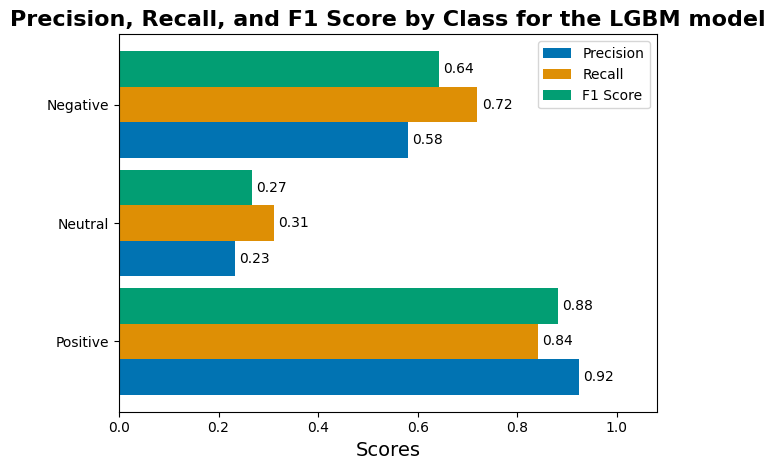

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns

y_test = df_final_test_set['VOTE']
y_preds = df_final_test_set['lgbm_final_preds']

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_preds, average=None, labels=[1, 0, -1])

# Create a list of class labels
class_labels = ['Positive', 'Neutral', 'Negative']

# Plotting
x = np.arange(len(class_labels))  # x-axis values
width = 0.3  # width of bars

# Define the colorblind-friendly palette
colors = sns.color_palette("colorblind")

accuracy = accuracy_score(y_test, y_preds)
print("LGBM model accuracy in the final test set data =", accuracy)

fig, ax = plt.subplots()
rects1 = ax.barh(x, precision, width, color=colors[0], label='Precision')
rects2 = ax.barh(x + width, recall, width, color=colors[1], label='Recall')
rects3 = ax.barh(x + 2 * width, f1, width, color=colors[2], label='F1 Score')

# Add some text for labels, title, and custom y-axis tick labels
ax.set_xlabel('Scores', fontsize=14)
ax.set_title('Precision, Recall, and F1 Score by Class for the LGBM model', fontsize=16, fontweight='bold')
ax.set_yticks(x + width)
ax.set_yticklabels(class_labels)
ax.legend()

# Add value labels next to the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.2f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.xlim([0, 1.08])  # Set the x-axis limits to ensure consistent scale

plt.tight_layout()
plt.show()

Next for the BERT model:

DistilBert model accuracy in the final test set data = 0.906881376275255


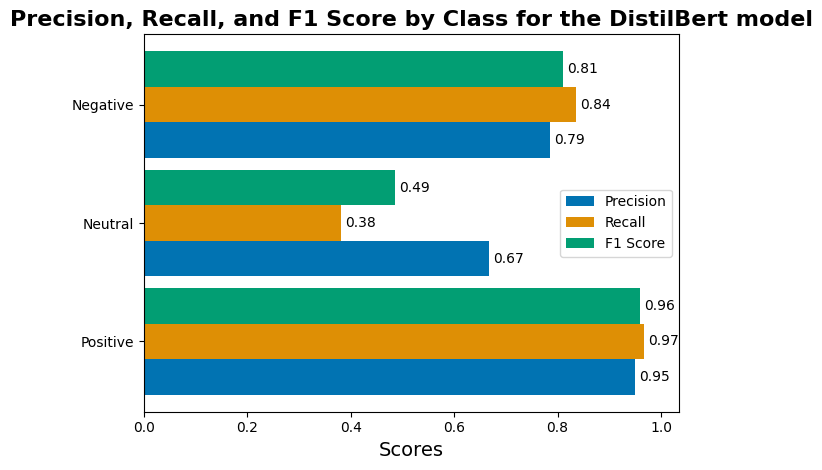

In [ ]:
y_test = df_final_test_set['VOTE']
y_preds = df_final_test_set['bert_final_preds']

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_preds, average=None, labels=[1, 0, -1])

# Create a list of class labels
class_labels = ['Positive', 'Neutral', 'Negative']

# Plotting
x = np.arange(len(class_labels))  # x-axis values
width = 0.3  # width of bars

# Define the colorblind-friendly palette
colors = sns.color_palette("colorblind")

accuracy = accuracy_score(y_test, y_preds)
print("DistilBert model accuracy in the final test set data =", accuracy)

fig, ax = plt.subplots()
rects1 = ax.barh(x, precision, width, color=colors[0], label='Precision')
rects2 = ax.barh(x + width, recall, width, color=colors[1], label='Recall')
rects3 = ax.barh(x + 2 * width, f1, width, color=colors[2], label='F1 Score')

# Add some text for labels, title, and custom y-axis tick labels
ax.set_xlabel('Scores', fontsize=14)
ax.set_title('Precision, Recall, and F1 Score by Class for the DistilBert model', fontsize=16, fontweight='bold')
ax.set_yticks(x + width)
ax.set_yticklabels(class_labels)
ax.legend()

# Add value labels next to the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.2f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.xlim([0, 1.035])  # Set the x-axis limits to ensure consistent scale

plt.tight_layout()
plt.show()

For the stackedRandomForest classifier:

Stacking ensemble model accuracy in the final test set data = 0.8945789157831566


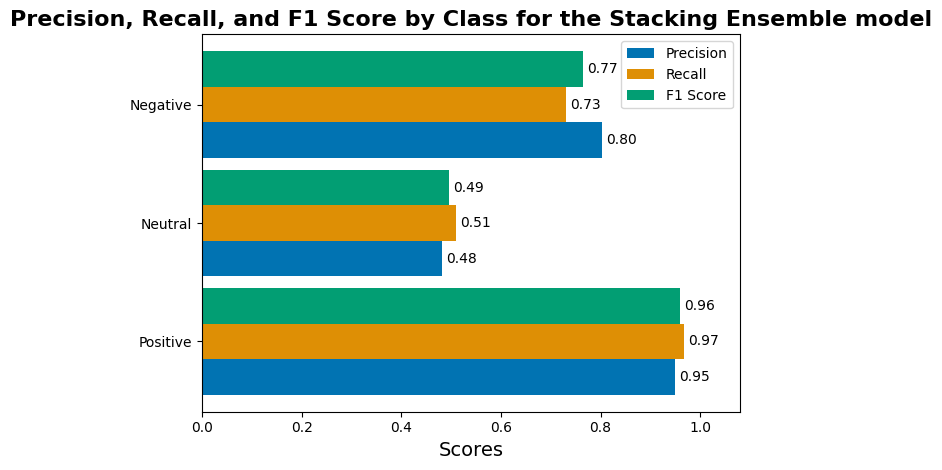

In [ ]:
y_test = df_final_test_set['VOTE']
y_preds = stackClassifier_y_test_final_preds

# Calculate precision, recall, and F1 score for each class
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_preds, average=None, labels=[1, 0, -1])

# Create a list of class labels
class_labels = ['Positive', 'Neutral', 'Negative']

# Plotting
x = np.arange(len(class_labels))  # x-axis values
width = 0.3  # width of bars

# Define the colorblind-friendly palette
colors = sns.color_palette("colorblind")

accuracy = accuracy_score(y_test, y_preds)
print("Stacking ensemble model accuracy in the final test set data =", accuracy)

fig, ax = plt.subplots()
rects1 = ax.barh(x, precision, width, color=colors[0], label='Precision')
rects2 = ax.barh(x + width, recall, width, color=colors[1], label='Recall')
rects3 = ax.barh(x + 2 * width, f1, width, color=colors[2], label='F1 Score')

# Add some text for labels, title, and custom y-axis tick labels
ax.set_xlabel('Scores', fontsize=14)
ax.set_title('Precision, Recall, and F1 Score by Class for the Stacking Ensemble model', fontsize=16, fontweight='bold')
ax.set_yticks(x + width)
ax.set_yticklabels(class_labels)
ax.legend()

# Add value labels next to the bars
def autolabel(rects):
    for rect in rects:
        width = rect.get_width()
        ax.annotate('{:.2f}'.format(width),
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(3, 0),  # 3 points horizontal offset
                    textcoords="offset points",
                    ha='left', va='center')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

plt.xlim([0, 1.08])  # Set the x-axis limits to ensure consistent scale

plt.tight_layout()
plt.show()

Confusion Matrices in final_test_set:

In [ ]:
from sklearn.metrics import confusion_matrix

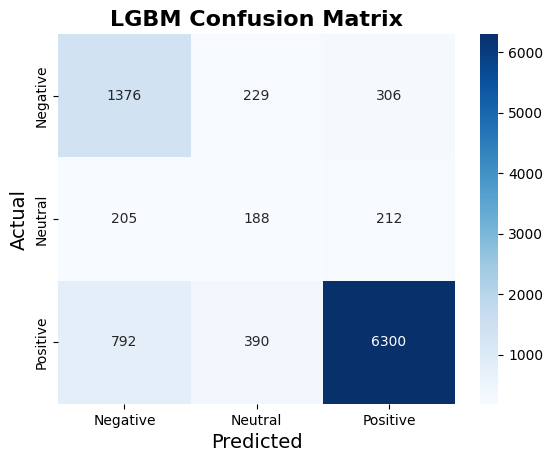

In [ ]:
lgbm_preds= df_final_test_set['lgbm_final_preds']
y_true = df_final_test_set['VOTE']

# Map class encodings to labels
class_labels = {-1: "Negative", 0: "Neutral", 1: "Positive"}
predicted_labels = [class_labels[p] for p in lgbm_preds]
actual_labels = [class_labels[a] for a in y_true]

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=list(class_labels.values()))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_labels.values()), yticklabels=list(class_labels.values()))

# # Add labels and title
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("Actual", fontsize = 14)
plt.title("LGBM Confusion Matrix", fontsize=16, fontweight = 'bold')

# Show the plot
plt.show()

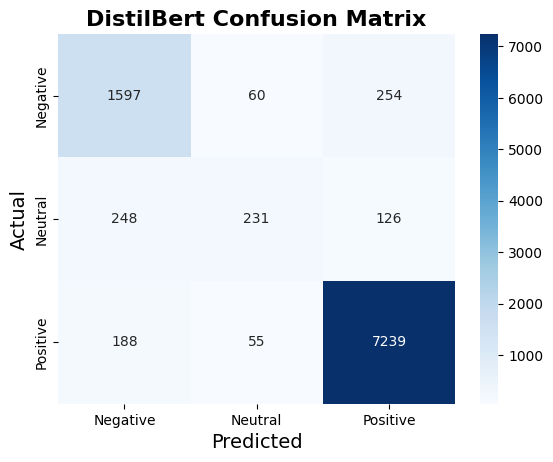

In [ ]:
bert_preds= df_final_test_set['bert_final_preds']
y_true = df_final_test_set['VOTE']

# Map class encodings to labels
class_labels = {-1: "Negative", 0: "Neutral", 1: "Positive"}
predicted_labels = [class_labels[p] for p in bert_preds]
actual_labels = [class_labels[a] for a in y_true]

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=list(class_labels.values()))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_labels.values()), yticklabels=list(class_labels.values()))

# # Add labels and title
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("Actual", fontsize = 14)
plt.title("DistilBert Confusion Matrix", fontsize = 16, fontweight = 'bold')

# Show the plot
plt.show()

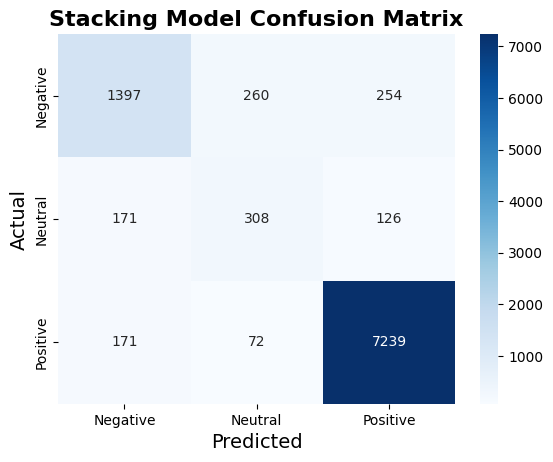

In [ ]:
stacked_preds= stackClassifier_y_test_final_preds
y_true = df_final_test_set['VOTE']

# Map class encodings to labels
class_labels = {-1: "Negative", 0: "Neutral", 1: "Positive"}
predicted_labels = [class_labels[p] for p in stacked_preds]
actual_labels = [class_labels[a] for a in y_true]

# Compute confusion matrix
cm = confusion_matrix(actual_labels, predicted_labels, labels=list(class_labels.values()))

# Create a heatmap using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(class_labels.values()), yticklabels=list(class_labels.values()))

# # Add labels and title
plt.xlabel("Predicted", fontsize = 14)
plt.ylabel("Actual", fontsize = 14)
plt.title("Stacking Model Confusion Matrix", fontsize = 16, fontweight = 'bold')

# Show the plot
plt.show()

### Accuracy Barplots of all models on final test set:

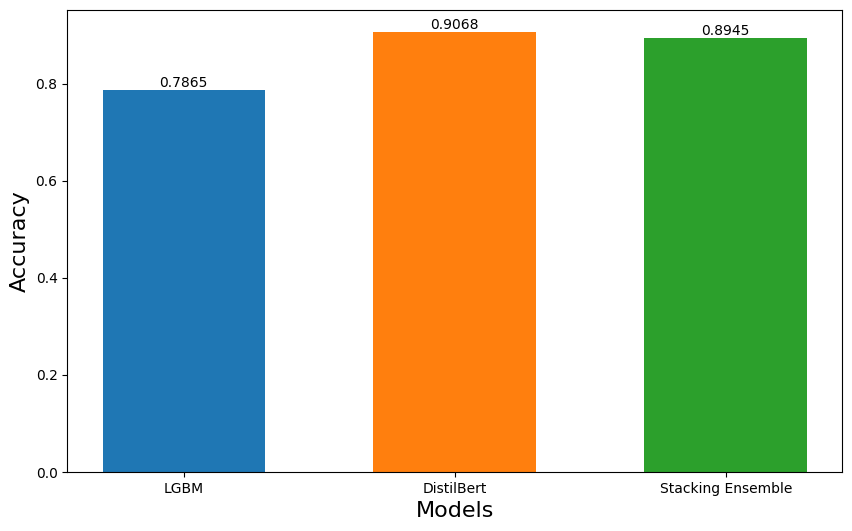

In [ ]:
# Accuracy metrics and model names
accuracy_metrics = [accLgbmFinal, accBertFinal, accStackFinal]
model_names = ['LGBM', 'DistilBert', 'Stacking Ensemble']

# Define colorblind-friendly colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the barplot
plt.figure(figsize=(10, 6))  # Adjust the figure size as desired
bars = plt.bar(model_names, accuracy_metrics, color=colors, width=0.6)  # Adjust the width as desired

# Set plot title and labels
# plt.title("Accuracy of models")
plt.xlabel("Models", fontsize = 16)
plt.ylabel("Accuracy", fontsize = 16)

# Increase the y-axis range
# plt.ylim(0.7, 1.0)  # Adjust the range as desired

# Display accuracy values on top of the bars
for bar, accuracy in zip(bars, accuracy_metrics):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f"{accuracy:.4f}", ha='center', va='bottom')

# Display the plot
plt.show()